<a href="https://colab.research.google.com/github/kohlia123/Senior-Design/blob/main/visualize_spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import spectrogram

In [2]:
!pip install mne mne-bids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 13.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/ieeg_ieds_bids"

In [5]:
import mne

In [37]:
bids_root = data_path
sub = "sub-01"
task = "sleep"

edf_path = os.path.join(bids_root, "sub-01","ieeg", "sub-01_task-sleep_ieeg.edf")
events_tsv = os.path.join(bids_root, "sub-01", "ieeg","sub-01_task-sleep_events.tsv")

print(edf_path)
print(events_tsv)

raw = mne.io.read_raw_edf(edf_path, preload=True)
print(raw)

/content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_ieeg.edf
/content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_events.tsv
Extracting EDF parameters from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_ieeg.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180999  =      0.000 ...   180.999 secs...
<RawEDF | sub-01_task-sleep_ieeg.edf, 22 x 181000 (181.0 s), ~30.4 MiB, data loaded>


In [38]:
# High pass filter 1 Hz / low pass filter 80 Hz
raw.filter(1., 80.)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 3301 samples (3.301 s)



<RawEDF | sub-01_task-sleep_ieeg.edf, 22 x 181000 (181.0 s), ~30.4 MiB, data loaded>

In [43]:
raw

<RawEDF | sub-01_task-sleep_ieeg.edf, 22 x 181000 (181.0 s), ~30.4 MiB, data loaded>

In [39]:
print(os.listdir(data_path))

# read EDF（iEEG）
raw_path = os.path.join(data_path,"sub-01","ieeg", "sub-01_task-sleep_ieeg.edf")
raw = mne.io.read_raw_edf(raw_path, preload=True)
print(raw)
print(raw.ch_names[:10])

# read events.tsv
events_path = os.path.join(data_path, "sub-01", "ieeg","sub-01_task-sleep_events.tsv")
events_df = pd.read_csv(events_path, sep="\t")
events_df.head()


['participants.tsv', 'participants.json', 'dataset_description.json', 'README.txt', '.DS_Store', 'sub-02', 'sub-04', 'sub-05', 'sub-03', 'sub-16', 'sub-11', 'sub-18', 'sub-20', 'sub-21', 'sub-19', 'sub-09', 'sub-07', 'sub-17', 'sub-10', 'sub-06', 'sub-01', 'sub-08', 'sub-12', 'sub-15', 'derivatives', 'sub-23', 'sub-25', 'sub-22', 'sub-24', 'sub-14', 'sub-13']
Extracting EDF parameters from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_ieeg.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180999  =      0.000 ...   180.999 secs...
<RawEDF | sub-01_task-sleep_ieeg.edf, 22 x 181000 (181.0 s), ~30.4 MiB, data loaded>
['LA1', 'LA2', 'LA3', 'LMH1', 'LMH2', 'LMH3', 'RA1', 'RA3', 'RMH1', 'RMH2']


,onset,duration,trial_type,sample
0,0.802,0.0,Rt sharp,802
1,5.614,0.0,Rt sharp,5614
2,5.906,0.0,Rt sharp,5906
3,12.864,0.0,Rt sharp,12864
4,17.583,0.0,Rt sharp,17583


61
onset            0.802
duration           0.0
trial_type    Rt sharp
sample             802
Name: 0, dtype: object
Sampling freq: 1000.0


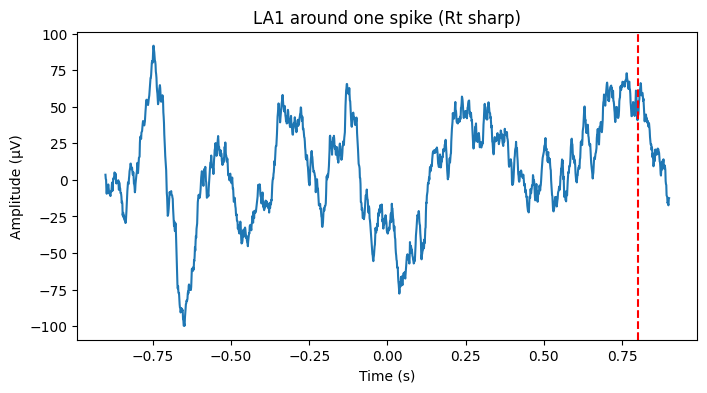

In [22]:

spike_events = events_df[events_df["trial_type"].isin(["Rt sharp", "Lt sharp"])]
print(len(spike_events))


first_event = spike_events.iloc[0]
event_sample = int(first_event["sample"])
print(first_event)

sfreq = raw.info["sfreq"]
print("Sampling freq:", sfreq)

tmin = -1
tmax = 1

start_sample = int(event_sample + tmin * sfreq)
end_sample   = int(event_sample + tmax * sfreq)


start_sample = max(start_sample, 0)
end_sample = min(end_sample, len(raw.times))

data, times = raw[:, start_sample:end_sample]


ch_name = "LA1"
ch_idx = raw.ch_names.index(ch_name)

plt.figure(figsize=(8, 4))
plt.plot(times - times[len(times)//2], data[ch_idx] * 1e6)  # µV
plt.axvline(first_event["onset"],linestyle="--", color="r")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"{ch_name} around one spike ({first_event['trial_type']})")
plt.show()


In [14]:
def compute_spike_amplitude(segment):
    # segment: 1D numpy array, Volt
    return (segment.max() - segment.min()) * 1e6  # µV


In [40]:
def compute_spike_duration(segment, sfreq, frac=0.3):
    """
    segment: 1D numpy array, Volt
    frac: threshold = frac * peak_abs
    """
    import numpy as np

    abs_seg = np.abs(segment)
    peak = abs_seg.max()
    if peak == 0:
        return 0.0

    thr = frac * peak
    above = np.where(abs_seg >= thr)[0]
    if len(above) == 0:
        return 0.0

    # the time difference bewteen first threshold to last threshold
    dur_samples = above[-1] - above[0] + 1
    dur_sec = dur_samples / sfreq
    return dur_sec * 1000  # ms


In [41]:
results = []

for i in range(len(spike_events)):
    row = spike_events.loc[i]
    center_sample = int(row["sample"])
    start = center_sample + int(tmin * sfreq)
    stop  = center_sample + int(tmax * sfreq)

    data, times = raw.get_data(
        picks=[ch_name],
        start=start,
        stop=stop,
        return_times=True
    )
    seg = data[0]  # 1D

    amp_uv = compute_spike_amplitude(seg)
    dur_ms = compute_spike_duration(seg, sfreq, frac=0.3)

    results.append({
        "index": i,
        "trial_type": row["trial_type"],
        "onset": row["onset"],
        "amplitude_uv": amp_uv,
        "duration_ms": dur_ms
    })

spike_stats = pd.DataFrame(results)
spike_stats.head()


,index,trial_type,onset,amplitude_uv,duration_ms
0,0,Rt sharp,0.802,191.442062,1625.0
1,1,Rt sharp,5.614,308.949076,1709.0
2,2,Rt sharp,5.906,308.949076,1988.0
3,3,Rt sharp,12.864,268.021777,1962.0
4,4,Rt sharp,17.583,203.350287,1972.0


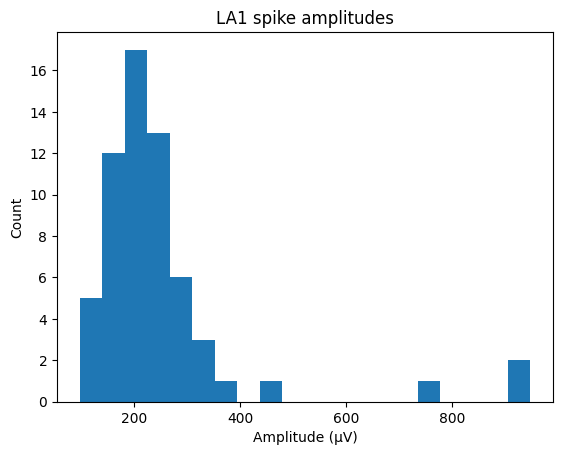

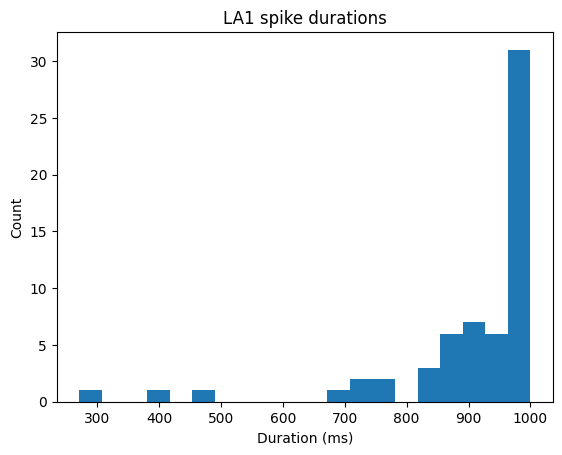

In [35]:
plt.figure()
plt.hist(spike_stats["amplitude_uv"], bins=20)
plt.xlabel("Amplitude (µV)")
plt.ylabel("Count")
plt.title(f"{ch_name} spike amplitudes")
plt.show()

plt.figure()
plt.hist(spike_stats["duration_ms"], bins=20)
plt.xlabel("Duration (ms)")
plt.ylabel("Count")
plt.title(f"{ch_name} spike durations")
plt.show()


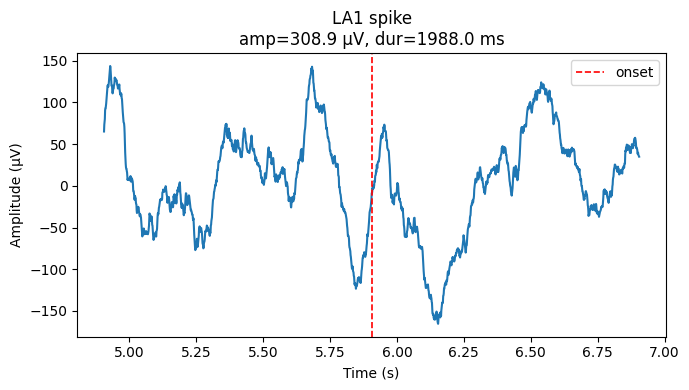

In [42]:
i = 2  # the 1st spike
row = spike_events.loc[i]
center_sample = int(row["sample"])
start = center_sample + int(tmin * sfreq)
stop  = center_sample + int(tmax * sfreq)

data, times = raw.get_data(
    picks=[ch_name],
    start=start,
    stop=stop,
    return_times=True
)
seg = data[0]

amp_uv = compute_spike_amplitude(seg)
dur_ms = compute_spike_duration(seg, sfreq, frac=0.3)

onset_sec = row["onset"]

plt.figure(figsize=(7,4))
plt.plot(times, seg * 1e6)
plt.axvline(onset_sec, color='r', linestyle='--', linewidth=1.2, label='onset')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"{ch_name} spike\namp={amp_uv:.1f} µV, dur={dur_ms:.1f} ms")
plt.tight_layout()
plt.show()


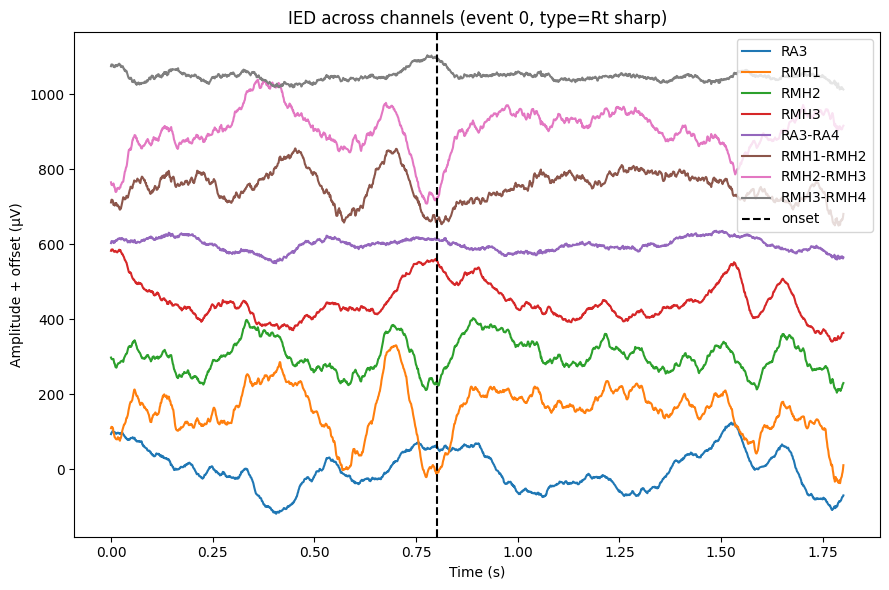

In [34]:
import numpy as np
import matplotlib.pyplot as plt


i = 0  # first spike
row = spike_events.iloc[i]
center_sample = int(row["sample"])
onset_sec = row["onset"]

start = center_sample + int(tmin * sfreq)
stop  = center_sample + int(tmax * sfreq)

# multiple channels
channel_list = ['RA3', 'RMH1', 'RMH2', 'RMH3', 'RA3-RA4', 'RMH1-RMH2', 'RMH2-RMH3', 'RMH3-RMH4']
picks = [raw.ch_names.index(ch) for ch in channel_list]

data, times = raw.get_data(
    picks=picks,
    start=start,
    stop=stop,
    return_times=True
)

# spike onset
onset_time_zero = onset_sec
window_center_time = times[len(times)//2]
onset_in_window = onset_time_zero - window_center_time


plt.figure(figsize=(9, 6))
offset = 150

for idx, ch in enumerate(channel_list):
    seg = data[idx] * 1e6  # µV
    plt.plot(times, seg + idx * offset, label=ch)


plt.axvline(onset_sec, color='k', linestyle='--', label="onset")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude + offset (µV)")
plt.title(f"IED across channels (event {i}, type={row['trial_type']})")
plt.legend()
plt.tight_layout()
plt.show()
